# Modelando funções complexas com Redes Neurais Artificiais

In [ ]:
#!pip install -q tensorflow
#!pip install -q -U keras

## Implementando uma rede MLP - multi-layer perceptron

In [60]:
import numpy as np
import sys

class NeuralNetMLP(object):
    
    def __init__(self, n_hidden=30,
                 epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.epochs = epochs
        self.eta = eta # Learning Rate
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    # NÃO ALTERAR
    def _forward(self, X):
        """Compute forward propagation step"""

        z_h = np.dot(X, self.w_h) + self.b_h

        a_h = self._sigmoid(z_h)

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2)

        return cost

    def predict(self, X):
        """
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    # NÃO ALTERAR
    def fit(self, X_train, y_train, X_valid, y_valid):

        
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ######################## 

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output  
        self.b_out = np.zeros(n_output) # num_classes
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx]) 

                
                ##################
                # Backpropagation
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Weight updates
                self.w_h -= self.eta * grad_w_h 
                self.b_h -= self.eta * grad_b_h

                self.w_out -= self.eta * grad_w_out 
                self.b_out -= self.eta * grad_b_out 

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float64) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float64) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

# TESTE DO MODELO - 2025

In [72]:
X = [[0., 0.], [1., 1.], [2., 2.],[3.,3.]] * 100
y = [0, 1, 2, 3] * 100

X = np.array(X)
y  = np.array(y) 

n_epochs = 100#100 
nn = NeuralNetMLP(n_hidden=100, 
                  epochs=n_epochs, 
                  eta=0.001, 
                  minibatch_size=100, # 64, 128, 256 
                  shuffle=True,
                  seed=1)



X_train, y_train, X_valid, y_valid = X[:300], y[:300], X[300:], y[300:]

nn.fit(X_train, y_train, X_valid, y_valid)

100/100 | Cost: 377.28 | Train/Valid Acc.: 100.00%/100.00% 

In [73]:
X.shape, X_train.shape, X_valid.shape

((400, 2), (300, 2), (100, 2))

In [74]:
i = 0
x1 = np.array(X[i]).reshape(1, -1)
nn.predict(x1)

array([0])

In [75]:
for i in range(4):
    x1 = np.array(X[i]).reshape(1, -1)
    print(nn.predict(x1))

[0]
[1]
[2]
[3]


# Treinando uma Rede Neural com as imagens de dígitos manuscritos

## Lendo o arquivo de imagens de dígitos

In [76]:
%%time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import keras
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape,  X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
CPU times: user 260 ms, sys: 25.1 ms, total: 285 ms
Wall time: 381 ms


## Reshape dos dados

In [77]:
X_train = X_train.reshape(X_train.shape[0],  28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28) 

print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


## Treino do Modelo

In [78]:
%%time 

# Aproximate training time: 14 mins, MacbookPro I5, 2.6 GHz Intel Core i5, 8 GB 1600 MHz DDR3, n_hidden=100
# Aproximate training time: 17 mins, n_hidden=200
# Aproximate training time: 20 mins, n_hidden=200, l2=0.1
# Aproximate training time: 21 mins, n_hidden=200, l2=0.02, n_epochs=200, eta=0.0005
# Aproximate training time: 6 mins, n_hidden=200, l2=0.02, n_epochs=200, 200/200 | 
#    Macbook I7,                       Cost: 5227.82 | Train/Valid Acc.: 99.29%/98.40% 


n_epochs = 15 

nn = NeuralNetMLP(n_hidden=100, 
                  epochs=n_epochs, 
                  eta=0.0005, # 0.1, 0.3 - 0.01, 0.1, 0.001, 0.0001
                  minibatch_size=100, # 64, 128, 256 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

15/15 | Cost: 29037.83 | Train/Valid Acc.: 92.39%/94.02% 

CPU times: user 47.5 s, sys: 12.4 s, total: 59.9 s
Wall time: 35 s


In [ ]:
# 14/14 | Cost: 28668.96 | Train/Valid Acc.: 92.41%/94.38% 
# Tempo Decorrido: 0:0:48
# Test accuracy: 92.02%

## Salvando o modelo para o disco 

In [ ]:
# O Modelo
nn

In [ ]:
atributos = list( nn.__dict__.keys() )
print('Atributos: ', atributos, sep="\n")

In [ ]:
print('Atributos:\n', '\n+'.join(atributos))

In [ ]:
import pickle
# save the model to disk
filename = 'neuralnet_model.pickle'
print('Saving file ' + filename + '...')
pickle.dump(nn, open(filename, 'wb'))
print('File Saved ' + filename + '.') 

## Carregando o modelo do disco

In [ ]:
# load the model from disk
print('Loading file' + filename + '...')
loaded_model = pickle.load(open(filename, 'rb'))
predict = loaded_model.predict(X_test)
result = sum(predict == y_test) / len(predict)
print(result)

## Exibindo as métricas da Rede Neural

In [ ]:
print('cost:', np.mean(nn.eval_['cost']))
print('train_acc:', np.mean(nn.eval_['train_acc']))
print('valid_acc:', np.mean(nn.eval_['valid_acc']))
nn.w_out[0]


---

## Plotando análises

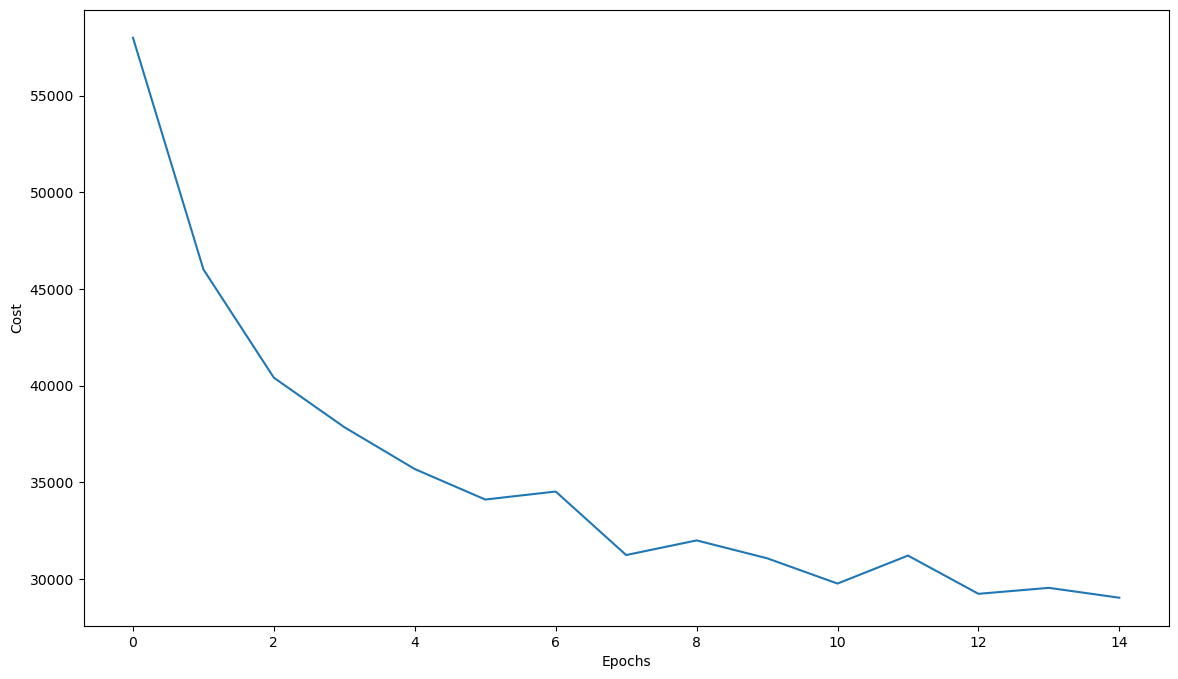

In [79]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [14,8]

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

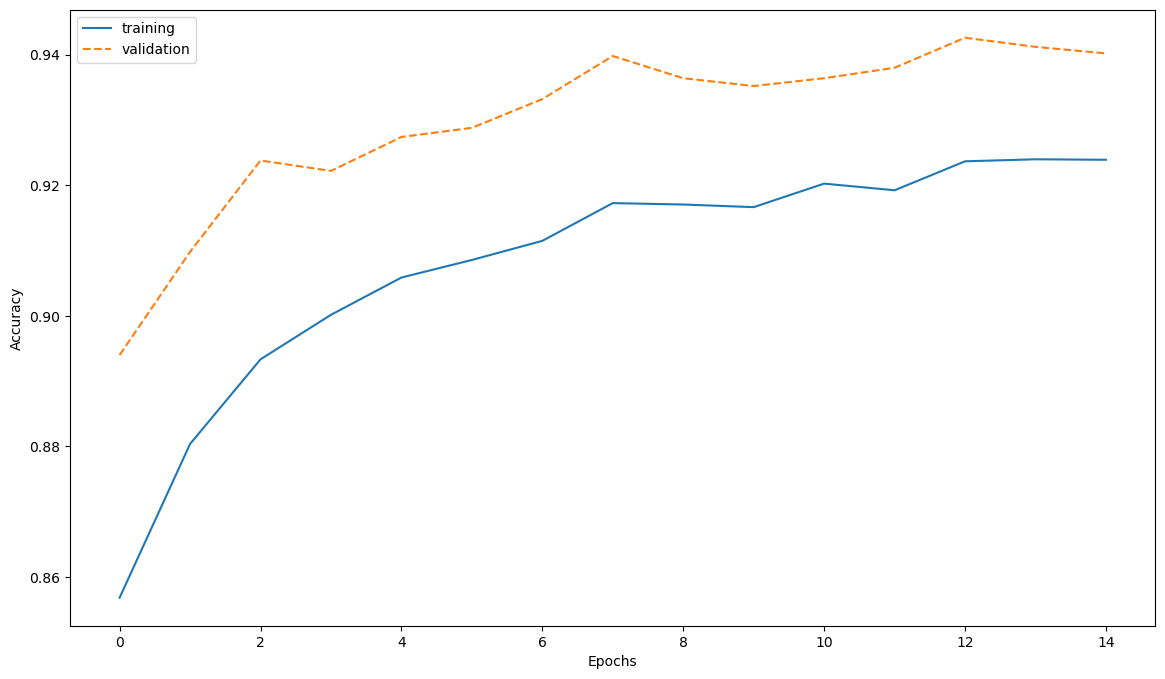

In [80]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.savefig('images/12_08.png', dpi=300)
plt.show()

In [81]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float64) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 92.26%


## Plotando algumas predições erradas do conjunto de teste 

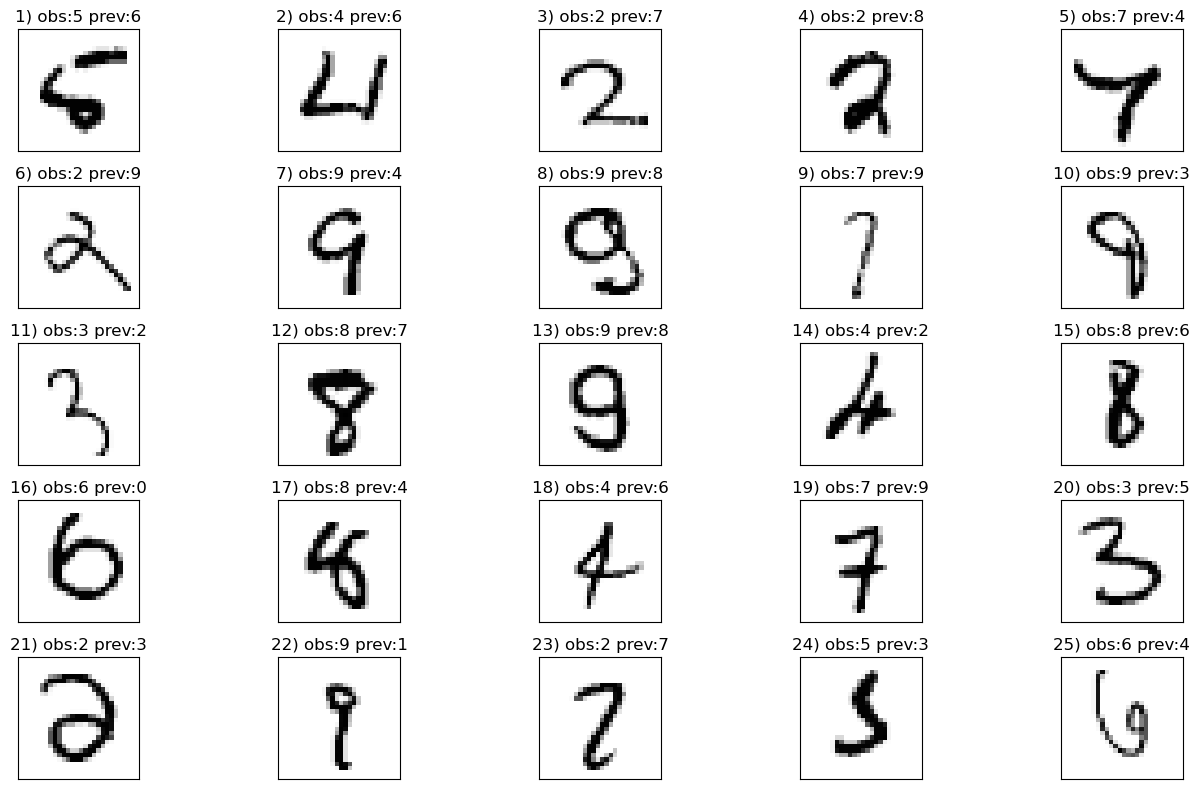

In [82]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) obs:%d prev:%d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.rcParams["figure.figsize"] = [14,8]
plt.show()

---